In [1]:
import cv2 
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib 
import os 

In [2]:
import pathlib

data_dir = tf.keras.utils.get_file( 
    "dataset.zip",
    "https://github.com/salmaKs/MLops-tuberculosis-XRay-detect/blob/main/dataset.zip?raw=true",
    extract=False)
import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

data_dir = pathlib.Path('/content/datasets/dataset')
print(data_dir)
print(os.path.abspath(data_dir))

\content\datasets\dataset
C:\content\datasets\dataset


In [10]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)
def list_files(directory):
    print("Listing all files and directories:")
    for root, _, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))

list_files(data_dir)



212
Listing all files and directories:
\content\datasets\dataset\poumon_sain\00000003_006.png
\content\datasets\dataset\poumon_sain\Normal-1.png
\content\datasets\dataset\poumon_sain\Normal-10.png
\content\datasets\dataset\poumon_sain\Normal-100.png
\content\datasets\dataset\poumon_sain\Normal-1000.png
\content\datasets\dataset\poumon_sain\Normal-1001.png
\content\datasets\dataset\poumon_sain\Normal-1002.png
\content\datasets\dataset\poumon_sain\Normal-1003.png
\content\datasets\dataset\poumon_sain\Normal-1004.png
\content\datasets\dataset\poumon_sain\Normal-1005.png
\content\datasets\dataset\poumon_sain\Normal-1006.png
\content\datasets\dataset\poumon_sain\Normal-1007.png
\content\datasets\dataset\poumon_sain\Normal-1008.png
\content\datasets\dataset\poumon_sain\Normal-1009.png
\content\datasets\dataset\poumon_sain\Normal-101.png
\content\datasets\dataset\poumon_sain\Normal-1010.png
\content\datasets\dataset\poumon_sain\Normal-1011.png
\content\datasets\dataset\poumon_sain\Normal-1012

In [12]:
batch_size = 3
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)
     

Found 212 files belonging to 2 classes.
Using 170 files for training.
Found 212 files belonging to 2 classes.
Using 42 files for validation.
['poumon_sain', 'tuberculosis']


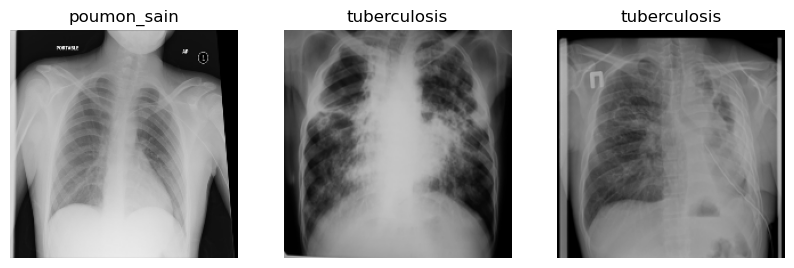

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

# Nombre de classes
num_classes = 2

# Générateur de données avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Préparation des données avec augmentation
train_data = datagen.flow_from_directory(data_dir, target_size=(200, 200), batch_size=32, class_mode='sparse')
val_data = datagen.flow_from_directory(data_dir, target_size=(200, 200), batch_size=32, class_mode='sparse')

# Base pré-entraînée (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
base_model.trainable = False  

# Construction du modèle
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5), 
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Ajout de TensorBoard pour suivre l'entraînement
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True)

# Entraînement du modèle
model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[tensorboard_callback]
)

# Optionnel : Fine-tuning (débloquer les couches supérieures)
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Apprentissage lent pour éviter de détruire les poids pré-entraînés
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[tensorboard_callback,early_stopping]
)

Found 212 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


C:\Users\HP\AppData\Local\Temp\ipykernel_11552\794491103.py:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.4829 - loss: 2.4039 - val_accuracy: 0.8585 - val_loss: 1.5117
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7319 - loss: 1.6446 - val_accuracy: 0.8679 - val_loss: 1.3657
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8550 - loss: 1.3803 - val_accuracy: 0.9340 - val_loss: 1.2088
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9203 - loss: 1.2089 - val_accuracy: 0.9528 - val_loss: 1.0890
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9284 - loss: 1.1090 - val_accuracy: 0.9575 - val_loss: 1.0166
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9349 - loss: 1.0507 - val_accuracy: 0.9528 - val_loss: 0.9517
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9514 - loss: 0.9551 - val_accuracy: 0.9717 - val_loss: 0.8861
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9274 - loss: 0.9929 - val_accuracy: 0.9906 - val_loss: 0.8222
Epoch 9/

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,952,072 (26.52 MB)

 Trainable params: 2,305,986 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,611,974 (17.59 MB)

In [32]:

model.save('cnn_model.keras')
# Get the absolute path where the model is saved
saved_model_path = os.path.abspath('cnn_model.keras')

# Print the full path
print(f"Model saved at: {saved_model_path}")


Model saved at: C:\Users\HP\cnn_model.keras
